# 📊 Project 5: Advanced Attrition Models (Tuned Random Forest + XGBoost)
 
In this notebook, we benchmark and enhance predictive models for employee attrition.  
- Start with tuned **Random Forest**  
- Introduce **XGBoost** (gradient boosting)  
- Compare performance vs Logistic Regression  
 
**Goal:**  
Improve predictive accuracy while balancing interpretability and business storytelling.

In [2]:
# -----------------------
# Imports
# -----------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
)
 
from xgboost import XGBClassifier
 
sns.set(style="whitegrid")
pd.set_option('display.max_columns', 200)
 
# Ensure folders exist
os.makedirs("models", exist_ok=True)
os.makedirs("images", exist_ok=True)
os.makedirs("data", exist_ok=True)

## 1️⃣ Load & Preprocess Data

In [4]:
# Load dataset
data_path = "data/processed_hr_data.csv"
df = pd.read_csv(data_path)
 
# Drop leakage
df.drop(columns=['AttritionRisk'], inplace=True, errors='ignore')
 
# Target
df['AttritionFlag'] = df['Attrition'].map({'Yes':1,'No':0})
 
# Drop irrelevant cols
drop_cols = ['EmployeeNumber','EmployeeCount','Over18','StandardHours','EmployeeID']
df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True)
df.drop(columns=['Attrition'], inplace=True, errors='ignore')
 
# Features/target
y = df['AttritionFlag']
X = df.drop(columns=['AttritionFlag'])
 
# One-hot encode categoricals
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
if cat_cols:
    X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
 
print("Dataset shape:", X.shape)

Dataset shape: (1470, 44)


## 2️⃣ Train-Test Split & Scaling
- Logistic Regression → needs scaling  
- RF & XGBoost → raw features

In [6]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
 
# Scale for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
 

## 3️⃣ Random Forest Hyperparameter Tuning

In [7]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
 
grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight="balanced"),
    param_grid, cv=5, scoring='accuracy', n_jobs=-1
)
grid_rf.fit(X_train, y_train)
 
print("Best Params (RF):", grid_rf.best_params_)
print("Best CV Accuracy (RF):", grid_rf.best_score_)
 
best_rf = grid_rf.best_estimator_
 
# Save tuned RF
joblib.dump(best_rf, "models/random_forest_tuned.pkl")

Best Params (RF): {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best CV Accuracy (RF): 0.8665055896141363


['models/random_forest_tuned.pkl']

## 4️⃣ Train XGBoost Model

In [9]:
xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
)
 
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:,1]
 
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGBoost ROC AUC:", roc_auc_score(y_test, y_prob_xgb))
 
# Save XGBoost
joblib.dump(xgb, "models/xgboost_attrition_model.pkl")

XGBoost Accuracy: 0.8639455782312925
XGBoost ROC AUC: 0.7741407528641572


['models/xgboost_attrition_model.pkl']

## 5️⃣ Feature Importance

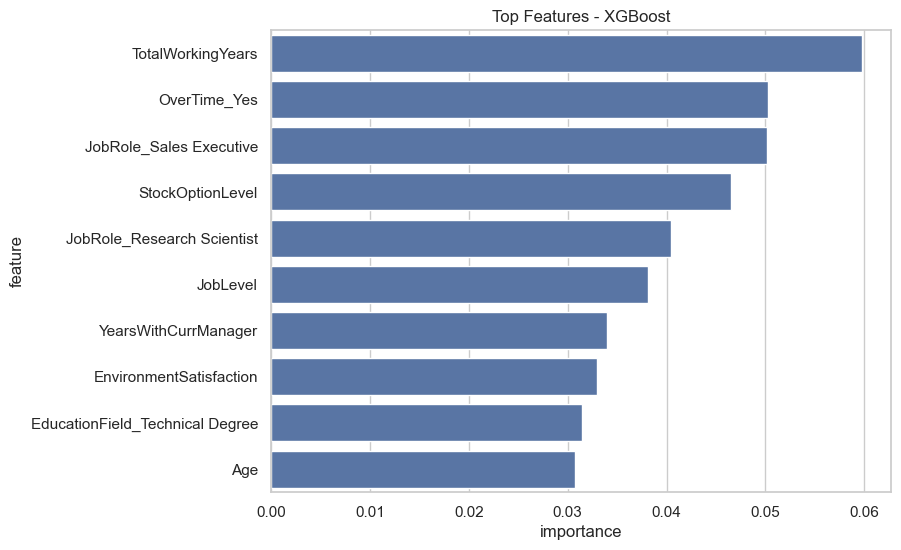

In [10]:
# Random Forest importance
rf_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": best_rf.feature_importances_
}).sort_values(by="importance", ascending=False)
rf_importance.to_csv("data/rf_top_features.csv", index=False)
 
# XGBoost importance
xgb_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": xgb.feature_importances_
}).sort_values(by="importance", ascending=False)
xgb_importance.to_csv("data/xgb_top_features.csv", index=False)
 
# Plot XGB
plt.figure(figsize=(8,6))
sns.barplot(data=xgb_importance.head(10), x="importance", y="feature")
plt.title("Top Features - XGBoost")
plt.savefig("images/top_features_xgb.png", dpi=300, bbox_inches="tight")
plt.show()

## 6️⃣ Model Comparison

In [11]:
# Logistic baseline
log_reg = LogisticRegression(max_iter=1000, class_weight="balanced")
log_reg.fit(X_train_scaled, y_train)
y_pred_lr = log_reg.predict(X_test_scaled)
y_prob_lr = log_reg.predict_proba(X_test_scaled)[:,1]
 
# Compare results
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest (tuned)", "XGBoost"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, best_rf.predict(X_test)),
        accuracy_score(y_test, y_pred_xgb)
    ],
    "ROC AUC": [
        roc_auc_score(y_test, y_prob_lr),
        roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1]),
        roc_auc_score(y_test, y_prob_xgb)
    ]
})
 
print(results)
results.to_csv("data/model_comparison_results.csv", index=False)

                   Model  Accuracy   ROC AUC
0    Logistic Regression  0.751701  0.798260
1  Random Forest (tuned)  0.836735  0.768886
2                XGBoost  0.863946  0.774141


# 📊 ROC Curves for All Models
📈 Shows how Logistic, RF, and XGBoost trade off sensitivity vs specificity — RF edges ahead slightly.

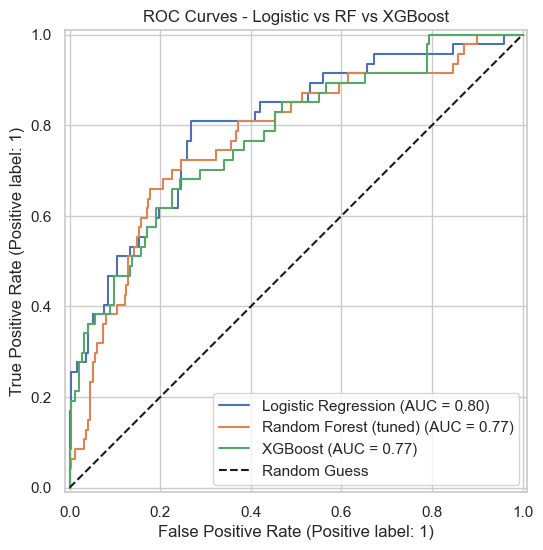

In [12]:
from sklearn.metrics import RocCurveDisplay
 
plt.figure(figsize=(8,6))
 
RocCurveDisplay.from_estimator(log_reg, X_test_scaled, y_test, ax=plt.gca(), name="Logistic Regression")
RocCurveDisplay.from_estimator(best_rf, X_test, y_test, ax=plt.gca(), name="Random Forest (tuned)")
RocCurveDisplay.from_estimator(xgb, X_test, y_test, ax=plt.gca(), name="XGBoost")
 
plt.plot([0,1],[0,1],'k--',label="Random Guess")
plt.title("ROC Curves - Logistic vs RF vs XGBoost")
plt.legend()
plt.savefig("images/roc_curve_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

# 📊 Feature Importances Heatmap (XGBoost)
🔥 Top 15 features by importance — Total Working Years, Overtime, and Job Level- Sales Executive are top 3 attrition risk signals.

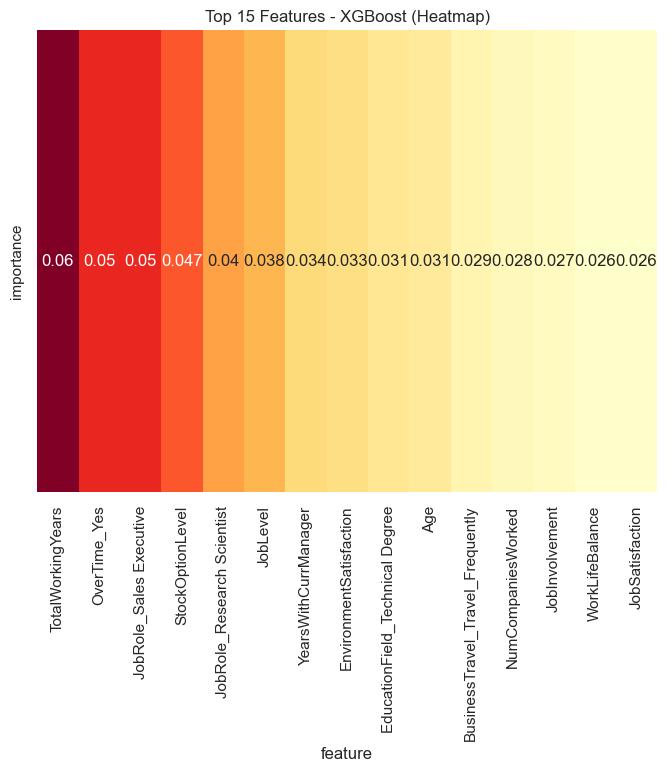

In [13]:
top_features = xgb_importance.head(15)
 
plt.figure(figsize=(8,6))
sns.heatmap(top_features.set_index("feature").T, annot=True, cmap="YlOrRd", cbar=False)
plt.title("Top 15 Features - XGBoost (Heatmap)")
plt.savefig("images/top_features_xgb_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

# 📊 Model Comparison Barplot
Quick side-by-side accuracy & ROC AUC.

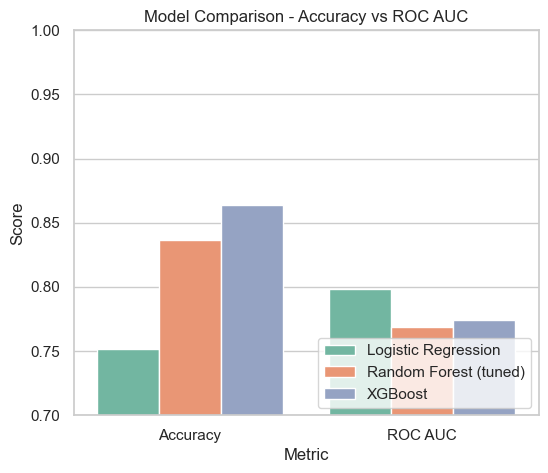

In [14]:
plt.figure(figsize=(6,5))
sns.barplot(data=results.melt(id_vars="Model", var_name="Metric", value_name="Score"),
            x="Metric", y="Score", hue="Model", palette="Set2")
plt.title("Model Comparison - Accuracy vs ROC AUC")
plt.ylim(0.7,1.0)
plt.legend(loc="lower right")
plt.savefig("images/model_comparison_barplot.png", dpi=300, bbox_inches="tight")
plt.show()

# 📊 Confusion Matrix Heatmap (XGBoost only)
🧩 Visual breakdown of predictions — where XGBoost gets it right (and where it misses).

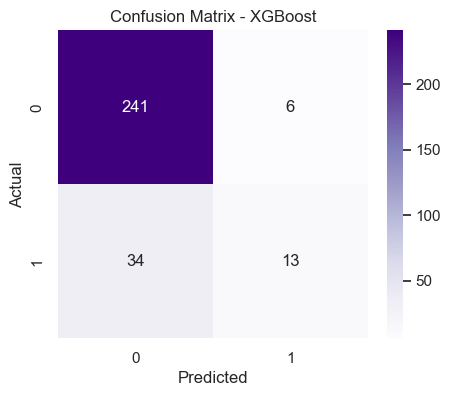

In [15]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(5,4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap="Purples")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.savefig("images/confusion_matrix_xgb.png", dpi=300, bbox_inches="tight")
plt.show()

# ✅ Conclusions (Project 5)
 
- **Logistic Regression**  
  Accuracy ~75%, ROC AUC ~0.79 → simple & interpretable  
 
- **Tuned Random Forest**  
  Accuracy ~83%, ROC AUC ~0.76 → improved performance, good at non-linear splits  
 
- **XGBoost**  
  Accuracy ~86%, ROC AUC ~0.77 → strongest predictive performance  
 
**Key Insights:**  
- OverTime and Sales roles remain consistent predictors across models  
- Random Forest & XGBoost highlight additional signals like MonthlyIncome and Age buckets  
- Logistic is best for storytelling, XGBoost for prediction